# Discrete Logarithm

The Discrete Logarithm Problem [[1](#DiscreteLog)] was shown by Shor [[2](#Shor)] to be solved in a polynomial time using quantum computers, while the fastest classical algorithms take a superpolynomial time. The problem is at least as hard as the factoring problem. In fact, the hardness of the problem is the basis for the Diffie-Hellman [[3](#DiffieHellman)] protocol for key exchange. 

## Formulating the Problem

* **Input:** A cyclic group $G = \langle g \rangle$ with $g$ as a generator, and an element $x\in G$.

* **Promise:**  There is a number $s$ such that $g^s = x$.

* **Output:** $s$, the discrete logarithm: $s = \log_gx$.

*** 

In Shor's implementation, the order of $g$ is assumed to be known beforehand (for example, using the order finding algorithm). We also assume it in the demonstration. 

The Discrete Log problem is a specific example of the Abelian Hidden Subgroup Problem [[4](#HSP)] for the case of an additive group, with this function:
$$
f: \mathbb{Z}_N \times \mathbb{Z}_N \rightarrow G
$$
$$
f(\alpha, \beta) = x^\alpha g^\beta
$$

## Building the Algorithm with Classiq

The heart of the algorithm's logic is the implementation of the function
$$
|x_1\rangle|x_2\rangle|1\rangle \rightarrow |x_1\rangle|x_2\rangle|x^{x_1} g^{x_2}\rangle. 
$$

This is done using two applications of the modular exponentiation function, described in detail in the [Shor's Factoring Algorithm](https://short.classiq.io/shor) notebook. So here we import it from the Classiq library.

The `modular_exp` function accepts these arguments:
- `n: CInt` - modulo number
- `a: CInt` - base of the exponentiation
- `x: QArray[QBit]` - unsigned integer to multiply by the exponentiation
- `power: QArray[QBit]`- power of the exponentiation

So the function implements 
$|power\rangle|x\rangle \rightarrow |power\rangle|x \cdot a ^ {power}\mod n\rangle$.

In [1]:
from classiq import *


@qfunc
def discrete_log_oracle(
    g_generator: CInt,
    x_element: CInt,
    N_modulus: CInt,
    x1: QArray,
    x2: QArray,
    func_res: Output[QNum],
) -> None:
    allocate(ceiling(log(N_modulus, 2)), func_res)

    func_res ^= 1
    modular_exp(N_modulus, x_element, func_res, x1)
    modular_exp(N_modulus, g_generator, func_res, x2)

### Full Algorithm
1. Prepare uniform superposition over the first two quantum variables `x1`, `x2`. Each variable has size $\lceil \log r\rceil + \log({1/{\epsilon}})$. In the special case where $r$ is a power of 2,  $\log r$ is enough.
3. Compute `discrete_log_oracle` on the `func_res` variable. `func_res` is of size $\lceil \log N\rceil$.
4. Apply the inverse Fourier transform `x1`, `x2`.
5. Measure.

In [2]:
from classiq.qmod.symbolic import ceiling, log


@qfunc
def discrete_log(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    x1: Output[QArray],
    x2: Output[QArray],
    func_res: Output[QArray],
) -> None:
    reg_len = ceiling(log(order, 2))
    allocate(reg_len, x1)
    allocate(reg_len, x2)

    hadamard_transform(x1)
    hadamard_transform(x2)

    discrete_log_oracle(g, x, N, x1, x2, func_res)

    invert(lambda: qft(x1))
    invert(lambda: qft(x2))

After the inverse QFTs (under the assumption of $r=2^m$ for some $m$), the variables become
$$|\psi\rangle = \sum_{\nu\in\mathbb{Z}_r, \delta\in G}\omega^{\nu\delta}|\nu\cdot log_gx\rangle_{x_1}|\nu\rangle_{x_2}|\delta>_{func\_res}$$.

For every $\nu$ that has a multiplicative inverse in $\mathbb{Z}_r$, we can extract $s=\log_xg$ by multiplying the first variable result by its inverse.

If $r$ is not a power of 2, the variables get an approximation of |$\log_g(x)\cdot \nu/ r\rangle_{x_1} |\nu / r\rangle_{x_2}$. So we can use the continued fractions algorithm [[5](#ContinuedFraction)] to compute $\nu/r$, then use the same technique to calculate $\log_gx$.

*Note: Alternatively, you could implement the $QFT_{\mathbb{Z}_r}$ over general $r$, and instead of the uniform superposition, prepare the states: $\frac{1}{\sqrt{r}}\sum_{x\in\mathbb{r}}|x\rangle$ in `x1`, `x2`. Then, again, no continued fractions postprocessing is required.*

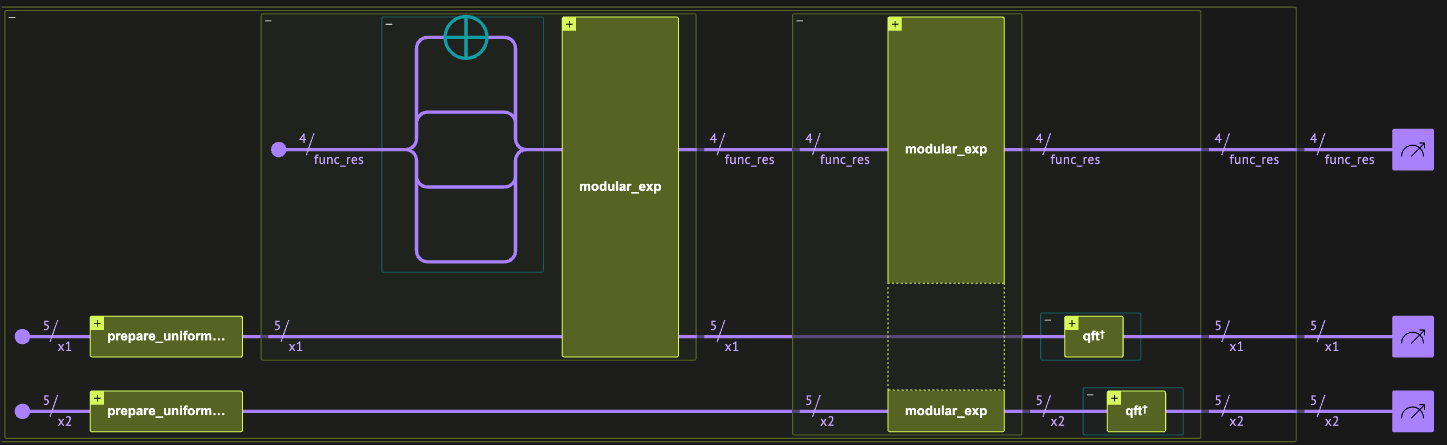

## Example:  $G = \mathbb{Z}_5^\times$

For this specific demonstration, we choose $G = \mathbb{Z}_5^\times$, with $g=3$ and $x=2$. With this setting, $log_gx=3$.

We choose this specific example because the order of the group $r=4$ is a power of $2$, so we can get the exact discrete logarithm without continued-fractions postprocessing. In other cases, we use a larger quantum variable for the exponents so the continued fractions postprocessing converges.

In [3]:
MODULU_NUM = 5
G_GENERATOR = 3
X_LOG_ARG = 2
ORDER = MODULU_NUM - 1  # as 5 is prime


@qfunc
def main(
    x1: Output[QNum],
    x2: Output[QNum],
    func_res: Output[QNum],
) -> None:
    discrete_log(G_GENERATOR, X_LOG_ARG, MODULU_NUM, ORDER, x1, x2, func_res)

In [4]:
qmod_Z5 = create_model(
    main,
    constraints=Constraints(max_width=13),
    preferences=Preferences(optimization_level=1),
    execution_preferences=ExecutionPreferences(num_shots=4000),
    out_file="discrete_log",
)

qprog_Z5 = synthesize(qmod_Z5)
show(qprog_Z5)

Quantum program link: https://platform.classiq.io/circuit/32pOy58GAt8k2oViuCeTHC58Z61


In [5]:
result_Z5 = execute(qprog_Z5).result_value()
result_Z5.dataframe

,x1,x2,func_res,count,probability,bitstring
0,3,1,3,275,0.06875,0110111
1,1,3,2,267,0.06675,0101101
2,1,3,4,267,0.06675,1001101
3,3,1,4,265,0.06625,1000111
4,3,1,1,263,0.06575,0010111
5,1,3,3,261,0.06525,0111101
6,0,0,4,256,0.06400,1000000
7,3,1,2,247,0.06175,0100111
8,2,2,4,247,0.06175,1001010
9,2,2,1,246,0.06150,0011010


Note that `func_res` is uncorrelated to the other variables, and we get uniform distribution, as expected. 

We take only the `x2` that are co-prime to $r=4$, so they have a multiplicative-inverse. Hence `x2=1,3` are the relevant results.
So we get two relevant results (for all different $\delta$s): $|1\rangle|3\rangle$, $|3\rangle|1\rangle$. All that remains to get the logarithm is to multiply `x1` by the inverse of `x2`:

In [6]:
for res in result_Z5.parsed_counts:
    if res.state["x2"] in [1, 3]:
        logarithm = res.state["x2"] * pow(res.state["x1"], -1, 4)
        assert logarithm == 3

Verify we received the correct discrete logarithm:

In [7]:
log_arg = (G_GENERATOR**logarithm) % MODULU_NUM
print(log_arg)
assert log_arg == X_LOG_ARG

2


And, indeed, both cases give the same result, which is exactly the discrete logarithm: $\log_32 \mod 5 = 3$.

## Example:  $G = \mathbb{Z}_{13}^\times$

In this case the order is not a power of 2. During circuit creation, we change the state preparation: instead of creating the entire uniform distribution on the `x1`, `x2` variables, we load them with the uniform superposition of only the first `#ORDER` states.

We do that using the `prepare_uniform_trimmed_state` library function, which efficiently prepares such a state.

In [8]:
MODULU_NUM = 13
G_GENERATOR = 7
X_LOG_ARG = 3
ORDER = 12


@qfunc
def discrete_log(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    x1: Output[QNum],
    x2: Output[QNum],
    func_res: Output[QNum],
) -> None:
    reg_len = ceiling(log(order, 2)) + 1

    # we define the variables with fraction places to ease the postprocessing
    allocate(reg_len, False, reg_len, x1)
    allocate(reg_len, False, reg_len, x2)

    prepare_uniform_trimmed_state(ORDER, x1)
    prepare_uniform_trimmed_state(ORDER, x2)

    discrete_log_oracle(g, x, N, x1, x2, func_res)

    invert(lambda: qft(x1))
    invert(lambda: qft(x2))


@qfunc
def main(
    x1: Output[QNum],
    x2: Output[QNum],
    func_res: Output[QNum],
) -> None:
    discrete_log(G_GENERATOR, X_LOG_ARG, MODULU_NUM, ORDER, x1, x2, func_res)

In [9]:
constraints = Constraints(max_width=23)
preferences = Preferences(optimization_level=1)
execution_preferences = ExecutionPreferences(num_shots=10000)
qmod_Z13 = create_model(
    main,
    constraints=constraints,
    preferences=preferences,
    execution_preferences=execution_preferences,
    out_file="discrete_log_large",
)

qprog_Z13 = synthesize(qmod_Z13)
show(qprog_Z13)

Quantum program link: https://platform.classiq.io/circuit/32pPLrTP6nbjmiYa10qe5fd6QuD


In [10]:
result_Z13 = execute(qprog_Z13).result_value()
df = result_Z13.dataframe
df.head(10)

,x1,x2,func_res,count,probability,bitstring
0,0.65625,0.59375,3,19,0.0019,00111001110101
1,0.00000,0.25000,9,18,0.0018,10010100000000
2,0.65625,0.09375,12,17,0.0017,11000001110101
3,0.34375,0.15625,1,16,0.0016,00010010101011
4,0.34375,0.90625,11,16,0.0016,10111110101011
5,0.68750,0.56250,2,15,0.0015,00101001010110
6,0.65625,0.09375,3,15,0.0015,00110001110101
7,0.34375,0.90625,5,15,0.0015,01011110101011
8,0.00000,0.00000,12,15,0.0015,11000000000000
9,0.65625,0.06250,12,15,0.0015,11000001010101


#### Postprocessing

We now have an additional step in postprocessing. We translate each result to the closest fraction with a denominator, which is the order:

In [11]:
def closest_fraction(x, denominator):
    return round(x * denominator)


df["x1_rounded"] = closest_fraction(df.x1, ORDER)
df["x2_rounded"] = closest_fraction(df.x2, ORDER)
df.head(10)

,x1,x2,func_res,count,probability,bitstring,x1_rounded,x2_rounded
0,0.65625,0.59375,3,19,0.0019,00111001110101,8.0,7.0
1,0.00000,0.25000,9,18,0.0018,10010100000000,0.0,3.0
2,0.65625,0.09375,12,17,0.0017,11000001110101,8.0,1.0
3,0.34375,0.15625,1,16,0.0016,00010010101011,4.0,2.0
4,0.34375,0.90625,11,16,0.0016,10111110101011,4.0,11.0
5,0.68750,0.56250,2,15,0.0015,00101001010110,8.0,7.0
6,0.65625,0.09375,3,15,0.0015,00110001110101,8.0,1.0
7,0.34375,0.90625,5,15,0.0015,01011110101011,4.0,11.0
8,0.00000,0.00000,12,15,0.0015,11000000000000,0.0,0.0
9,0.65625,0.06250,12,15,0.0015,11000001010101,8.0,1.0


Now, we take a sample where `x2` is co-prime to the order, such that we can get the logarithm by multiplying `x1` by the modular inverse. If the `x1`, `x2` registers are large enough, we are guaranteed to sample it with a good probability:

In [12]:
import numpy as np


def modular_inverse(x):
    return [pow(a, -1, ORDER) for a in x]


df = df[np.gcd(df.x2_rounded.astype(int), ORDER) == 1].copy()
df["x2_inverse"] = modular_inverse(df.x2_rounded.astype("int"))
df["logarithm"] = df.x1_rounded * df.x2_inverse % ORDER
df.head(10)

,x1,x2,func_res,count,probability,bitstring,x1_rounded,x2_rounded,x2_inverse,logarithm
0,0.65625,0.59375,3,19,0.0019,00111001110101,8.0,7.0,7,8.0
2,0.65625,0.09375,12,17,0.0017,11000001110101,8.0,1.0,1,8.0
4,0.34375,0.90625,11,16,0.0016,10111110101011,4.0,11.0,11,8.0
5,0.68750,0.56250,2,15,0.0015,00101001010110,8.0,7.0,7,8.0
6,0.65625,0.09375,3,15,0.0015,00110001110101,8.0,1.0,1,8.0
7,0.34375,0.90625,5,15,0.0015,01011110101011,4.0,11.0,11,8.0
9,0.65625,0.06250,12,15,0.0015,11000001010101,8.0,1.0,1,8.0
10,0.34375,0.43750,4,14,0.0014,01000111001011,4.0,5.0,5,8.0
11,0.31250,0.93750,5,14,0.0014,01011111001010,4.0,11.0,11,8.0
16,0.34375,0.93750,9,14,0.0014,10011111001011,4.0,11.0,11,8.0


In [13]:
assert len(df.logarithm) > 0
assert np.allclose(G_GENERATOR ** df.logarithm[:10] % MODULU_NUM, X_LOG_ARG)

## References

<a id='DiscreteLog'>[1]</a>: [Discrete Logarithm (Wikipedia)](https://en.wikipedia.org/wiki/Discrete_logarithm)

<a id='Shor94'>[2]</a>: [Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. IEEE, 1994.](https://ieeexplore.ieee.org/abstract/document/365700)

<a id='DiffieHellman'>[3]</a>: [Diffie-Hellman Key Exchange (Wikipedia)](https://en.wikipedia.org/wiki/Diffie%E2%80%93Hellman_key_exchange)

<a id='HSP'>[4]</a>: [Hidden Subgroup Problem (Wikipedia)](https://en.wikipedia.org/wiki/Hidden_subgroup_problem)

<a id='ContinuedFraction'>[5]</a>: [Continued Fraction (Wikipedia)](https://en.wikipedia.org/wiki/Continued_fraction)
